# Silver: Analyse von False Positives/Negatives

- **False Positives (FP)**: Fälschlich als PII erkannt
- **False Negatives (FN)**: Nicht erkannte PIIs

---

## Setup

In [1]:
import sys
from pathlib import Path

project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import re
import json
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple, Optional, Set
from dataclasses import dataclass, field
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

from src.pii_redactor import PIIRedactor, PIIType, PIIMatch

import spacy
try:
    nlp = spacy.load("de_core_news_lg")
    SPACY_AVAILABLE = True
except:
    SPACY_AVAILABLE = False

---

## 1. Datensätze

1. **Hugging Face Datensatz**: Echter PII-Datensatz für realistische Tests --> WikiANN-Datensatz von Hugging Face, der multilingual annotierte Named Entities enthält
2. **Synthetischer Datensatz**: Selbst erstellt mit schwierigen Edge-Cases

In [2]:
try:
    from datasets import load_dataset
    
    dataset = load_dataset("wikiann", "de", split="train[:50]")
    HF_AVAILABLE = True
    print(f"Hugging Face Datensatz 'wikiann' (Deutsch) geladen: {len(dataset)} Beispiele")
    print(f"Spalten: {dataset.column_names}")
    
    # 0 = O (Outside), 1 = B-PER, 2 = I-PER, 3 = B-ORG, 4 = I-ORG, 5 = B-LOC, 6 = I-LOC
    print("Tag-Schema: O=0, B-PER=1, I-PER=2, B-ORG=3, I-ORG=4, B-LOC=5, I-LOC=6")
    
except Exception as e:
    HF_AVAILABLE = False

Hugging Face Datensatz 'wikiann' (Deutsch) geladen: 50 Beispiele
Spalten: ['tokens', 'ner_tags', 'langs', 'spans']
Tag-Schema: O=0, B-PER=1, I-PER=2, B-ORG=3, I-ORG=4, B-LOC=5, I-LOC=6


In [3]:
# Hugging Face Daten aufbereiten --> Tags & PII festlegen die in den Datensatz kommen sollen
hf_examples = []

if HF_AVAILABLE:
    tag_list = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']
    
    for i, item in enumerate(dataset):
        # Tokens zu Text zusammenfügen
        tokens = item['tokens']
        text = " ".join(tokens)
        
        # NER-Labels extrahieren
        pii_entities = []
        current_entity = []
        current_type = None
        
        for token, tag_idx in zip(tokens, item['ner_tags']):
            tag = tag_list[tag_idx] if tag_idx < len(tag_list) else 'O'
            
            if tag.startswith("B-"):
                if current_entity:
                    pii_entities.append({"text": " ".join(current_entity), "type": current_type})
                current_entity = [token]
                current_type = tag[2:]  # --> z.B. "PER", "LOC", "ORG"
            elif tag.startswith("I-") and current_type == tag[2:]:
                current_entity.append(token)
            else:
                if current_entity:
                    pii_entities.append({"text": " ".join(current_entity), "type": current_type})
                current_entity = []
                current_type = None
        
        if current_entity:
            pii_entities.append({"text": " ".join(current_entity), "type": current_type})
        
        # Nur Beispiele mit PER oder LOC (relevante PIIs) hinzufügen
        pii_only = [e for e in pii_entities if e['type'] in ['PER', 'LOC']]
        if pii_only:
            hf_examples.append({
                "id": f"hf_{i}",
                "text": text,
                "expected_pii": pii_only,
                "source": "huggingface",
                "category": "huggingface",
                "difficulty": "medium"
            })
    
    # Beispiele nach aufbereitung
    if hf_examples:
        print(f"\nBeispiel 1:")
        print(f"   Text: '{hf_examples[0]['text']}'")
        print(f"   PIIs: {hf_examples[0]['expected_pii']}")
        if len(hf_examples) > 1:
            print(f"\nBeispiel 2:")
            print(f"   Text: '{hf_examples[1]['text']}'")
            print(f"   PIIs: {hf_examples[1]['expected_pii']}")
else:
    print("Datensatz wurde nicht geladen --> nur syntetischer Datensatz wird jetzt genutzt!!")


Beispiel 1:
   Text: 'als Teil der Savoyer Voralpen im Osten .'
   PIIs: [{'text': 'Savoyer Voralpen', 'type': 'LOC'}]

Beispiel 2:
   Text: 'WEITERLEITUNG Antonina Wladimirowna Kriwoschapka'
   PIIs: [{'text': 'Antonina Wladimirowna Kriwoschapka', 'type': 'PER'}]


### 1.2 Synthetischer Datensatz mit Edge-Cases (schwierigen Beispielen)

1. **Namen ohne Großbuchstaben** - z.B. "max mustermann"
2. **Ungewöhnliche Formate** - z.B. E-Mails mit Subdomains
3. **Ambige Beispiele** - z.B. "Paris" (Stadt oder Name?)
4. **Schwer erkennbare PIIs** - z.B. verschleierte Telefonnummern

In [4]:
synthetic_examples = [
    # === Namen ohne Großbuchstaben ===
    {
        "id": "syn_01",
        "text": "bitte kontaktieren sie max mustermann für weitere informationen.",
        "expected_pii": [{"text": "max mustermann", "type": "name"}],
        "category": "lowercase_names",
        "difficulty": "hard"
    },
    {
        "id": "syn_02",
        "text": "der kunde hans-peter müller hat angerufen.",
        "expected_pii": [{"text": "hans-peter müller", "type": "name"}],
        "category": "lowercase_names",
        "difficulty": "hard"
    },
    {
        "id": "syn_03",
        "text": "email von lisa_schmidt bekommen",
        "expected_pii": [{"text": "lisa_schmidt", "type": "name"}],
        "category": "lowercase_names",
        "difficulty": "hard"
    },
    
    # === Ungewöhnliche Formate ===
    {
        "id": "syn_04",
        "text": "Kontakt: user.name+filter@subdomain.example.co.uk",
        "expected_pii": [{"text": "user.name+filter@subdomain.example.co.uk", "type": "email"}],
        "category": "unusual_formats",
        "difficulty": "medium"
    },
    {
        "id": "syn_05",
        "text": "Erreichbar unter 0049(0)170-123 456 78",
        "expected_pii": [{"text": "0049(0)170-123 456 78", "type": "phone"}],
        "category": "unusual_formats",
        "difficulty": "hard"
    },
    {
        "id": "syn_06",
        "text": "IBAN: DE 89 3704 0044 05320130 00 (Sparkasse)",
        "expected_pii": [{"text": "DE 89 3704 0044 05320130 00", "type": "iban"}],
        "category": "unusual_formats",
        "difficulty": "medium"
    },
    {
        "id": "syn_07",
        "text": "Geb.-Datum: 3.5.90",
        "expected_pii": [{"text": "3.5.90", "type": "date_of_birth"}],
        "category": "unusual_formats",
        "difficulty": "hard"
    },
    
    # === Ambige Beispiele ===
    {
        "id": "syn_08",
        "text": "Meeting mit Paris und London (Mitarbeiter aus dem UK-Team)",
        "expected_pii": [
            {"text": "Paris", "type": "name"},
            {"text": "London", "type": "name"}
        ],
        "category": "ambiguous",
        "difficulty": "hard",
        "note": "Paris und London sind hier Personennamen, keine Städte"
    },
    {
        "id": "syn_09",
        "text": "Apple-Mitarbeiter Tim hat die neue Software vorgestellt.",
        "expected_pii": [{"text": "Tim", "type": "name"}],
        "category": "ambiguous",
        "difficulty": "medium",
        "note": "Apple ist hier Firma, nicht PII; Tim ist der Name"
    },
    {
        "id": "syn_10",
        "text": "Frau Dr. König arbeitet in der König-Apotheke.",
        "expected_pii": [{"text": "Dr. König", "type": "name"}],
        "category": "ambiguous",
        "difficulty": "hard",
        "note": "Nur der Personenname ist PII, nicht der Firmenname"
    },
    {
        "id": "syn_11",
        "text": "Jordan hat bei Jordan Sport eingekauft.",
        "expected_pii": [{"text": "Jordan", "type": "name", "position": "first"}],
        "category": "ambiguous",
        "difficulty": "very_hard",
        "note": "Erstes 'Jordan' ist Person, zweites ist Marke"
    },
    
    # === Schwer erkennbare PIIs ===
    {
        "id": "syn_12",
        "text": "Tel: eins sieben null - eins zwei drei vier fünf sechs sieben",
        "expected_pii": [{"text": "eins sieben null - eins zwei drei vier fünf sechs sieben", "type": "phone"}],
        "category": "obfuscated",
        "difficulty": "very_hard"
    },
    {
        "id": "syn_13",
        "text": "E-Mail: max[at]example[dot]de",
        "expected_pii": [{"text": "max[at]example[dot]de", "type": "email"}],
        "category": "obfuscated",
        "difficulty": "hard"
    },
    {
        "id": "syn_14",
        "text": "SSN: xxx-xx-1234 (letzte 4 Ziffern)",
        "expected_pii": [{"text": "xxx-xx-1234", "type": "ssn"}],
        "category": "obfuscated",
        "difficulty": "medium"
    },
    
    # === Multi-PII Sätze ===
    {
        "id": "syn_15",
        "text": "Hr. Schmidt (schmidt@firma.de, 0170/1234567) wohnt in der Hauptstr. 5, 80331 München.",
        "expected_pii": [
            {"text": "Hr. Schmidt", "type": "name"},
            {"text": "schmidt@firma.de", "type": "email"},
            {"text": "0170/1234567", "type": "phone"},
            {"text": "Hauptstr. 5, 80331 München", "type": "address"}
        ],
        "category": "multi_pii",
        "difficulty": "medium"
    },
    {
        "id": "syn_16",
        "text": "Kundennr. K-2024-001, Kreditkarte **** **** **** 4532, geb. 01.01.1980",
        "expected_pii": [
            {"text": "K-2024-001", "type": "id_number"},
            {"text": "**** **** **** 4532", "type": "credit_card"},
            {"text": "01.01.1980", "type": "date_of_birth"}
        ],
        "category": "multi_pii",
        "difficulty": "hard"
    },
    
    # === False Positive Kandidaten ===
    {
        "id": "syn_17",
        "text": "Die Seriennummer des Geräts ist 192.168.1.1 (nicht verwechseln mit IP).",
        "expected_pii": [],  # --> 192.168.1.1 KEINE IP, sondern Seriennummer
        "category": "false_positive_trap",
        "difficulty": "very_hard",
        "note": "Kontext zeigt: Es ist eine Seriennummer, keine IP"
    },
    {
        "id": "syn_18",
        "text": "Der Preis beträgt 123.45 EUR (Artikelnummer: 98765).",
        "expected_pii": [],  # --> Keine echten PIIs
        "category": "false_positive_trap",
        "difficulty": "easy"
    },
    {
        "id": "syn_19",
        "text": "Das Modell heißt Alpha-3000 von der TechCorp GmbH.",
        "expected_pii": [],  # --> Produktnamen und Firmennamen sind hier keine PIIs
        "category": "false_positive_trap",
        "difficulty": "medium"
    },
    
    # === Internationale Formate ===
    {
        "id": "syn_20",
        "text": "Österreichische IBAN: AT611904300234573201",
        "expected_pii": [{"text": "AT611904300234573201", "type": "iban"}],
        "category": "international",
        "difficulty": "easy"
    },
    {
        "id": "syn_21",
        "text": "Contact: +1 (555) 123-4567 (US number)",
        "expected_pii": [{"text": "+1 (555) 123-4567", "type": "phone"}],
        "category": "international",
        "difficulty": "medium"
    },
    {
        "id": "syn_22",
        "text": "Marie-Claire Müller-Lüdenscheid aus Garmisch-Partenkirchen",
        "expected_pii": [
            {"text": "Marie-Claire Müller-Lüdenscheid", "type": "name"},
            {"text": "Garmisch-Partenkirchen", "type": "address"}
        ],
        "category": "international",
        "difficulty": "hard"
    },
    
    # === Edge Cases mit Sonderzeichen ===
    {
        "id": "syn_23",
        "text": "E-Mail: günther.müßig@öffentlich-rechtlich.de",
        "expected_pii": [{"text": "günther.müßig@öffentlich-rechtlich.de", "type": "email"}],
        "category": "special_chars",
        "difficulty": "hard"
    },
    {
        "id": "syn_24",
        "text": "O'Connor's E-Mail: brian.o'connor@example.ie",
        "expected_pii": [
            {"text": "O'Connor", "type": "name"},
            {"text": "brian.o'connor@example.ie", "type": "email"}
        ],
        "category": "special_chars",
        "difficulty": "very_hard"
    },
    {
        "id": "syn_25",
        "text": "IPv6: 2001:0db8:85a3:0000:0000:8a2e:0370:7334",
        "expected_pii": [{"text": "2001:0db8:85a3:0000:0000:8a2e:0370:7334", "type": "ip_address"}],
        "category": "special_chars",
        "difficulty": "hard"
    }
]

# Anzahl-Kategorien
categories = defaultdict(list)
for ex in synthetic_examples:
    categories[ex['category']].append(ex['id'])

print("\nKategorien:")
for cat, examples in categories.items():
    print(f"  {cat}: {len(examples)} Beispiele")


Kategorien:
  lowercase_names: 3 Beispiele
  unusual_formats: 4 Beispiele
  ambiguous: 4 Beispiele
  obfuscated: 3 Beispiele
  multi_pii: 2 Beispiele
  false_positive_trap: 3 Beispiele
  international: 3 Beispiele
  special_chars: 3 Beispiele


### 1.3 Datensätze kombinieren

In [5]:
all_examples = synthetic_examples.copy()

if hf_examples:
    # --> Nur Beispiele mit PIIs nehmen
    hf_with_pii = [ex for ex in hf_examples if ex['expected_pii']]
    all_examples.extend(hf_with_pii[:25])  # --> max. 25 HF-Beispiele

print(f"Gesamter Datensatz: {len(all_examples)} Beispiele")

Gesamter Datensatz: 50 Beispiele


---

## 2. PII-Erkennung

In [6]:
regex_redactor = PIIRedactor(use_ner=False)

if SPACY_AVAILABLE:
    hybrid_redactor = PIIRedactor(use_ner=True, ner_model="de_core_news_lg")
else:
    hybrid_redactor = regex_redactor

NER-Modell 'de_core_news_lg' erfolgreich geladen.


In [7]:
def normalize_text(text: str) -> str:
    return text.lower().strip()

def find_overlap(detected: List[str], expected: List[str]) -> Tuple[List[str], List[str], List[str]]:
    detected_norm = {normalize_text(d): d for d in detected}
    expected_norm = {normalize_text(e): e for e in expected}
    
    tp = []
    fp = []
    fn = []
    
    # TP
    for norm, orig in detected_norm.items():
        matched = False
        for exp_norm, exp_orig in expected_norm.items():
            if norm in exp_norm or exp_norm in norm:
                tp.append(orig)
                matched = True
                break
        if not matched:
            fp.append(orig)
    
    # FN
    for exp_norm, exp_orig in expected_norm.items():
        found = False
        for det_norm in detected_norm.keys():
            if exp_norm in det_norm or det_norm in exp_norm:
                found = True
                break
        if not found:
            fn.append(exp_orig)
    
    return tp, fp, fn

def evaluate_detection(examples: List[dict], method: str = "hybrid") -> pd.DataFrame:
    
    results = []
    
    if method == "ner":
        redactor = hybrid_redactor  # --> NER braucht den Redactor mit geladenem spaCy-Modell
    elif method == "hybrid":
        redactor = hybrid_redactor
    else:
        redactor = regex_redactor
    
    for ex in examples:
        text = ex['text']
        expected = [p['text'] for p in ex['expected_pii']]
        
        # Erkennung
        if method == "regex":
            matches = redactor.detect_regex(text)
        elif method == "ner" and SPACY_AVAILABLE:
            matches = redactor.detect_ner(text) 
        else:
            matches = redactor.detect(text, method=method)
        
        detected = [m.text for m in matches]
        
        # Vergleich
        tp, fp, fn = find_overlap(detected, expected)
        
        results.append({
            'id': ex['id'],
            'text': text[:50] if len(text) > 50 else text,
            'category': ex.get('category', 'huggingface'),
            'difficulty': ex.get('difficulty', 'unknown'),
            'expected_count': len(expected),
            'detected_count': len(detected),
            'true_positives': len(tp),
            'false_positives': len(fp),
            'false_negatives': len(fn),
            'tp_items': tp,
            'fp_items': fp,
            'fn_items': fn,
            'precision': len(tp) / len(detected) if detected else 1.0,
            'recall': len(tp) / len(expected) if expected else 1.0
        })
    
    return pd.DataFrame(results)

In [8]:
regex_results = evaluate_detection(all_examples, method="regex")

if SPACY_AVAILABLE:
    ner_results = evaluate_detection(all_examples, method="ner")
    hybrid_results = evaluate_detection(all_examples, method="hybrid")
else:
    ner_results = regex_results.copy()
    hybrid_results = regex_results.copy()

---

## 3. Analyse --> FP

--> fälschlicherweise als PII erkennt

In [9]:
all_fps = []
for _, row in hybrid_results.iterrows():
    for fp in row['fp_items']:
        all_fps.append({
            'example_id': row['id'],
            'category': row['category'],
            'text': row['text'],
            'false_positive': fp
        })

fp_df = pd.DataFrame(all_fps)

if not fp_df.empty:
    print(f"\nGesamt False Positives: {len(fp_df)}")
    
    print("\nTop False Positives:")
    
    fp_counts = fp_df['false_positive'].value_counts().head(10)
    for fp_text, count in fp_counts.items():
        print(f"  '{fp_text}' - {count}x falsch erkannt")
    
else:
    print("Keine False Positives gefunden!")


Gesamt False Positives: 17

Top False Positives:
  'WEITERLEITUNG' - 2x falsch erkannt
  'Geb.-Datum' - 1x falsch erkannt
  'Meeting' - 1x falsch erkannt
  'UK-Team' - 1x falsch erkannt
  'König-Apotheke' - 1x falsch erkannt
  'Tel' - 1x falsch erkannt
  'SSN' - 1x falsch erkannt
  'Kundennr' - 1x falsch erkannt
  '192.168.1.1' - 1x falsch erkannt
  '123.45' - 1x falsch erkannt


In [10]:
# FP-Beispiele
if not fp_df.empty:
    for i, (_, row) in enumerate(fp_df.head(10).iterrows()):
        print(f"\nBeispiel {row['example_id']} ({row['category']}):")
        print(f"Text: \"{row['text']}\"")
        print(f"FP: \"{row['false_positive']}\"")


Beispiel syn_07 (unusual_formats):
Text: "Geb.-Datum: 3.5.90"
FP: "Geb.-Datum"

Beispiel syn_08 (ambiguous):
Text: "Meeting mit Paris und London (Mitarbeiter aus dem "
FP: "Meeting"

Beispiel syn_08 (ambiguous):
Text: "Meeting mit Paris und London (Mitarbeiter aus dem "
FP: "UK-Team"

Beispiel syn_10 (ambiguous):
Text: "Frau Dr. König arbeitet in der König-Apotheke."
FP: "König-Apotheke"

Beispiel syn_12 (obfuscated):
Text: "Tel: eins sieben null - eins zwei drei vier fünf s"
FP: "Tel"

Beispiel syn_14 (obfuscated):
Text: "SSN: xxx-xx-1234 (letzte 4 Ziffern)"
FP: "SSN"

Beispiel syn_16 (multi_pii):
Text: "Kundennr. K-2024-001, Kreditkarte **** **** **** 4"
FP: "Kundennr"

Beispiel syn_17 (false_positive_trap):
Text: "Die Seriennummer des Geräts ist 192.168.1.1 (nicht"
FP: "192.168.1.1"

Beispiel syn_18 (false_positive_trap):
Text: "Der Preis beträgt 123.45 EUR (Artikelnummer: 98765"
FP: "123.45"

Beispiel syn_18 (false_positive_trap):
Text: "Der Preis beträgt 123.45 EUR (Artikelnummer

---

## 4. --> False Negatives

- Fälle, bei echte PIIs übersehen werden

In [11]:
all_fns = []
for _, row in hybrid_results.iterrows():
    for fn in row['fn_items']:
        all_fns.append({
            'example_id': row['id'],
            'category': row['category'],
            'difficulty': row['difficulty'],
            'text': row['text'],
            'false_negative': fn
        })

fn_df = pd.DataFrame(all_fns)

if not fn_df.empty:
    print(f"\nGesamt False Negatives: {len(fn_df)}")    
else:
    print("Keine False Negatives gefunden!")


Gesamt False Negatives: 12


In [12]:
# FN-Beispiele
if not fn_df.empty:
    for i, (_, row) in enumerate(fn_df.head(15).iterrows()):
        print(f"\nBeispiel {row['example_id']} ({row['category']}, {row['difficulty']}):")
        print(f"Text: \"{row['text']}\"")
        print(f"NICHT ERKANNT: \"{row['false_negative']}\"")


Beispiel syn_03 (lowercase_names, hard):
Text: "email von lisa_schmidt bekommen"
NICHT ERKANNT: "lisa_schmidt"

Beispiel syn_07 (unusual_formats, hard):
Text: "Geb.-Datum: 3.5.90"
NICHT ERKANNT: "3.5.90"

Beispiel syn_09 (ambiguous, medium):
Text: "Apple-Mitarbeiter Tim hat die neue Software vorges"
NICHT ERKANNT: "Tim"

Beispiel syn_10 (ambiguous, hard):
Text: "Frau Dr. König arbeitet in der König-Apotheke."
NICHT ERKANNT: "Dr. König"

Beispiel syn_12 (obfuscated, very_hard):
Text: "Tel: eins sieben null - eins zwei drei vier fünf s"
NICHT ERKANNT: "eins sieben null - eins zwei drei vier fünf sechs sieben"

Beispiel syn_13 (obfuscated, hard):
Text: "E-Mail: max[at]example[dot]de"
NICHT ERKANNT: "max[at]example[dot]de"

Beispiel syn_16 (multi_pii, hard):
Text: "Kundennr. K-2024-001, Kreditkarte **** **** **** 4"
NICHT ERKANNT: "**** **** **** 4532"

Beispiel syn_24 (special_chars, very_hard):
Text: "O'Connor's E-Mail: brian.o'connor@example.ie"
NICHT ERKANNT: "O'Connor"

Beispiel syn_

---

## 5. Vergleich Regex vs. NER

In [13]:
comparison_data = []

for i, ex in enumerate(synthetic_examples):
    regex_row = regex_results[regex_results['id'] == ex['id']].iloc[0]
    hybrid_row = hybrid_results[hybrid_results['id'] == ex['id']].iloc[0]
    
    comparison_data.append({
        'id': ex['id'],
        'category': ex.get('category', 'unknown'),
        'difficulty': ex.get('difficulty', 'unknown'),
        'expected': ex.get('expected_pii', []),
        'regex_recall': regex_row['recall'],
        'regex_precision': regex_row['precision'],
        'hybrid_recall': hybrid_row['recall'],
        'hybrid_precision': hybrid_row['precision'],
        'regex_fn': regex_row['fn_items'],
        'hybrid_fn': hybrid_row['fn_items']
    })

comparison_df = pd.DataFrame(comparison_data)

print("VERGLEICH: Regex vs. Hybrid nach Kategorie\n")

category_summary = comparison_df.groupby('category').agg({
    'regex_recall': 'mean',
    'regex_precision': 'mean',
    'hybrid_recall': 'mean',
    'hybrid_precision': 'mean'
}).round(3)

print(category_summary.to_string())

VERGLEICH: Regex vs. Hybrid nach Kategorie

                     regex_recall  regex_precision  hybrid_recall  hybrid_precision
category                                                                           
ambiguous                   0.000            1.000          0.750             0.625
false_positive_trap         1.000            0.333          1.000             0.000
international               0.667            1.000          1.000             0.833
lowercase_names             0.000            1.000          0.667             1.000
multi_pii                   0.708            1.000          1.083             0.833
obfuscated                  0.000            1.000          0.333             0.500
special_chars               0.167            1.000          0.500             1.000
unusual_formats             1.250            1.000          1.250             0.750


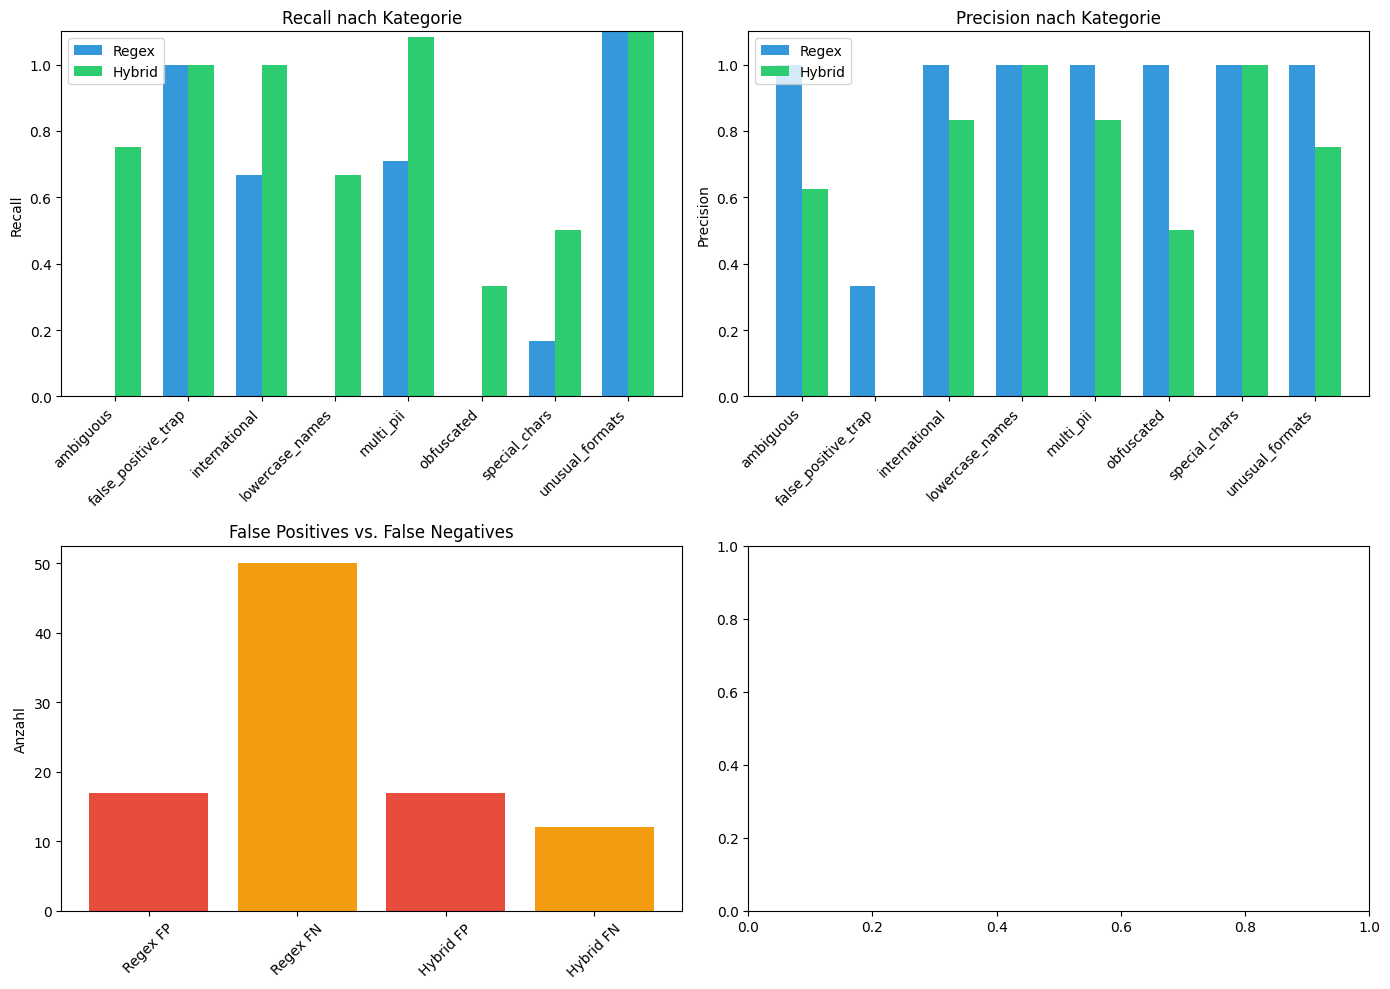

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# --> Recall nach Kategorie
categories = category_summary.index.tolist()
x = np.arange(len(categories))
width = 0.35

axes[0, 0].bar(x - width/2, category_summary['regex_recall'], width, label='Regex', color='#3498db')
axes[0, 0].bar(x + width/2, category_summary['hybrid_recall'], width, label='Hybrid', color='#2ecc71')
axes[0, 0].set_ylabel('Recall')
axes[0, 0].set_title('Recall nach Kategorie')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(categories, rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].set_ylim(0, 1.1)

# Precision nach Kategorie
axes[0, 1].bar(x - width/2, category_summary['regex_precision'], width, label='Regex', color='#3498db')
axes[0, 1].bar(x + width/2, category_summary['hybrid_precision'], width, label='Hybrid', color='#2ecc71')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Precision nach Kategorie')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(categories, rotation=45, ha='right')
axes[0, 1].legend()
axes[0, 1].set_ylim(0, 1.1)

# --> FP/FN Verteilung
fp_fn_data = {
    'Regex FP': hybrid_results['false_positives'].sum(),
    'Regex FN': regex_results['false_negatives'].sum(),
    'Hybrid FP': hybrid_results['false_positives'].sum(),
    'Hybrid FN': hybrid_results['false_negatives'].sum()
}
colors = ['#e74c3c', '#f39c12', '#e74c3c', '#f39c12']
axes[1, 0].bar(fp_fn_data.keys(), fp_fn_data.values(), color=colors)
axes[1, 0].set_ylabel('Anzahl')
axes[1, 0].set_title('False Positives vs. False Negatives')
axes[1, 0].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(project_root / 'exports' / 'fp_fn_analysis.png', dpi=150)
plt.show()

---

## 6. Test mit LLM

In [ ]:
LLM_AVAILABLE = False
llm = None

try:
    from llama_cpp import Llama
    
    possible_paths = [
        Path.home() / ".cache" / "llama" / "llama-3.2-3b-q4km.gguf",
        Path("/pii-detection-llm/models/llama-3.2-3b-q4km/llama-3.2-3b-instruct-q4_k_m.gguf"),
    ]
    
    for path in possible_paths:
        if path.exists():
            llm = Llama(model_path=str(path), n_ctx=2048, n_threads=4, verbose=False)
            LLM_AVAILABLE = True
            print(f"Modell geladen: {path.name}")
            break
    
    if not LLM_AVAILABLE:
        print("Kein Modell gefunden")
except ImportError:
    print("llama-cpp-python nicht installiert")

llama_context: n_ctx_per_seq (2048) < n_ctx_train (131072) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64

Modell geladen: llama-3.2-3b-instruct-q4_k_m.gguf


In [16]:
def test_pii_leakage_with_llm(examples: List[dict], n_samples: int = 5) -> pd.DataFrame:
    results = []
    
    # Samples mit FN
    fn_examples = [ex for ex in examples if any(
        hybrid_results[hybrid_results['id'] == ex['id']]['fn_items'].values[0]
    )]
    
    samples = fn_examples[:n_samples] if fn_examples else examples[:n_samples]
    
    for ex in samples:
        text = ex['text']
        expected_pii = [p['text'] for p in ex.get('expected_pii', [])]
        
        # Maskierung
        redaction = hybrid_redactor.redact(text)
        
        # LLM-Anfrage
        prompt = f"""Fasse den folgenden Text kurz zusammen:

{redaction.redacted_text}

Zusammenfassung:"""
        
        if LLM_AVAILABLE:
            response = llm(prompt, max_tokens=100, stop=["\n\n"])
            answer = response['choices'][0]['text'].strip()
        else:
            answer = "[LLM nicht verfügbar]"
        
        # Prüfen ob PIIs in Antwort
        leaked_pii = [pii for pii in expected_pii if pii.lower() in answer.lower()]
        
        results.append({
            'id': ex['id'],
            'category': ex.get('category', 'unknown'),
            'original_pii_count': len(expected_pii),
            'masked_pii_count': len(redaction.matches),
            'leaked_pii': leaked_pii,
            'leakage_count': len(leaked_pii),
            'answer_preview': answer[:100]
        })
    
    return pd.DataFrame(results)

# Test
leakage_results = test_pii_leakage_with_llm(synthetic_examples, n_samples=5)

print("\nPII-Leakage Analyse:")
for _, row in leakage_results.iterrows():
    print(f"\n{row['id']} ({row['category']}):")
    print(f"  Original PIIs: {row['original_pii_count']}")
    print(f"  Maskiert: {row['masked_pii_count']}")
    print(f"  Geleakt: {row['leakage_count']} - {row['leaked_pii']}")


PII-Leakage Analyse:

syn_03 (lowercase_names):
  Original PIIs: 1
  Maskiert: 0
  Geleakt: 0 - []

syn_07 (unusual_formats):
  Original PIIs: 1
  Maskiert: 1
  Geleakt: 0 - []

syn_09 (ambiguous):
  Original PIIs: 1
  Maskiert: 0
  Geleakt: 1 - ['Tim']

syn_10 (ambiguous):
  Original PIIs: 1
  Maskiert: 1
  Geleakt: 1 - ['Dr. König']

syn_12 (obfuscated):
  Original PIIs: 1
  Maskiert: 1
  Geleakt: 0 - []


---

## 7. Zusammenfassung und Export

In [17]:
total_examples = len(all_examples)
total_expected_pii = sum(len(ex.get('expected_pii', [])) for ex in all_examples)

regex_total_tp = regex_results['true_positives'].sum()
regex_total_fp = regex_results['false_positives'].sum()
regex_total_fn = regex_results['false_negatives'].sum()

hybrid_total_tp = hybrid_results['true_positives'].sum()
hybrid_total_fp = hybrid_results['false_positives'].sum()
hybrid_total_fn = hybrid_results['false_negatives'].sum()

def calc_f1(tp, fp, fn):
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    return {'precision': precision, 'recall': recall, 'f1': f1}

regex_metrics = calc_f1(regex_total_tp, regex_total_fp, regex_total_fn)
hybrid_metrics = calc_f1(hybrid_total_tp, hybrid_total_fp, hybrid_total_fn)

# Kategorien --> synthetischen Beispielen extrahieren
unique_categories = list(set(ex.get('category', 'unknown') for ex in synthetic_examples))

summary = {
    'notebook': '03_silver_analyse_fp_fn',
    'total_examples': total_examples,
    'synthetic_examples': len(synthetic_examples),
    'huggingface_examples': len(all_examples) - len(synthetic_examples),
    'total_expected_pii': total_expected_pii,
    'categories_analyzed': unique_categories,
    'regex_results': {
        'true_positives': int(regex_total_tp),
        'false_positives': int(regex_total_fp),
        'false_negatives': int(regex_total_fn),
        **regex_metrics
    },
    'hybrid_results': {
        'true_positives': int(hybrid_total_tp),
        'false_positives': int(hybrid_total_fp),
        'false_negatives': int(hybrid_total_fn),
        **hybrid_metrics
    },
    'most_problematic_categories': fn_df.groupby('category').size().sort_values(ascending=False).head(3).to_dict() if not fn_df.empty else {}
}

# Export
export_path = project_root / 'exports' / 'notebook_03_fp_fn_analysis.json'
with open(export_path, 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)
print(f"\nExport: {export_path}")

print(f"\nDatensatz:")
print(f"  Beispiele gesamt: {summary['total_examples']}")
print(f"  Erwartete PIIs: {summary['total_expected_pii']}")
print(f"\nRegex-Erkennung:")
print(f"  Precision: {regex_metrics['precision']:.3f}")
print(f"  Recall: {regex_metrics['recall']:.3f}")
print(f"  F1: {regex_metrics['f1']:.3f}")
print(f"\nHybrid-Erkennung:")
print(f"  Precision: {hybrid_metrics['precision']:.3f}")
print(f"  Recall: {hybrid_metrics['recall']:.3f}")
print(f"  F1: {hybrid_metrics['f1']:.3f}")



Export: /Volumes/Fanxiang S880E 2TB/M-APR/2_Semester/LLM/github-llm/pii-detection-llm/exports/notebook_03_fp_fn_analysis.json

Datensatz:
  Beispiele gesamt: 50
  Erwartete PIIs: 61

Regex-Erkennung:
  Precision: 0.765
  Recall: 0.206
  F1: 0.325

Hybrid-Erkennung:
  Precision: 0.761
  Recall: 0.818
  F1: 0.788


## Quellen und Referenzen

1. **WikiANN Dataset** - Multilingual Named Entity Recognition. [https://huggingface.co/datasets/wikiann](https://huggingface.co/datasets/wikiann)

2. **Precision, Recall, F1-Score** - Evaluationsmetriken für Klassifikation. [https://scikit-learn.org/stable/modules/model_evaluation.html](https://scikit-learn.org/stable/modules/model_evaluation.html)

3. **Microsoft Presidio** - Best Practices für PII-Erkennung. [https://microsoft.github.io/presidio/](https://microsoft.github.io/presidio/)

4. **Carlini et al. (2021)** - "Extracting Training Data from Large Language Models" - Motivation für robuste PII-Erkennung.